# Regularization

### Introduction

In [18]:
library(ggplot2)
library(gridExtra)
library(glmnet)
library(grid)
library(reshape)

Loading required package: Matrix

Loaded glmnet 4.0


Attaching package: 'reshape'


The following object is masked from 'package:Matrix':

    expand




In [34]:
births <- read.csv('Births.csv')
head(births) 

,ï..Year,NSW,ACT,QLD,SA,WA,TAS,VIC,NT
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,1977,78173,4381,35069,19086,20981,6739,59602,2923
2,1978,78190,4342,35054,18964,21094,6751,59364,2600
3,1979,77669,4217,34858,18403,20523,6947,58006,2747
4,1980,78859,4181,34666,18317,20354,6660,57768,2859
5,1981,80980,4193,37545,18960,21277,7112,58104,2749
6,1982,82185,4120,39403,19076,22236,7140,59842,3074


Create a total column

In [35]:
births[, 'Total'] <- rowSums((births[, 2:9]))
colnames(births)[1] <- "Year"

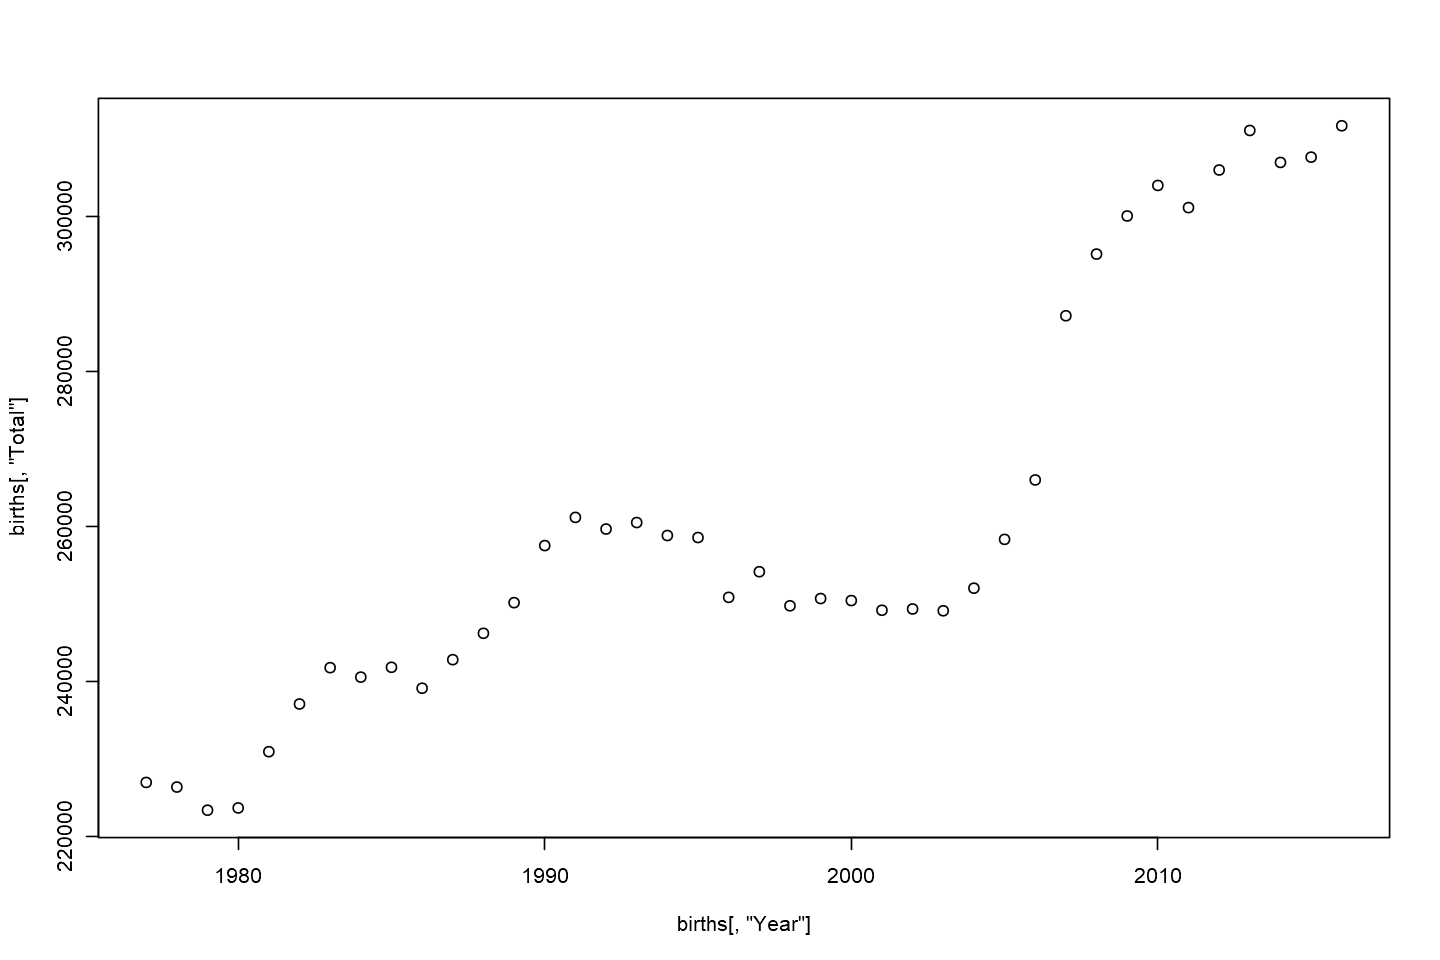

In [36]:
plot(births[, 'Year'], births[, 'Total'])

### Fitting Regressions

In [37]:
Y <- births[, 'Total']
X <- births[, 'Year']

overfit_model <- lm(Y ~ poly(X,20))
model <- lm(Y ~ poly(X,4))
underfit_model <- lm(Y ~ poly(X,1))

A <- predict(underfit_model)
B <- predict(model)
C <- predict(overfit_model)

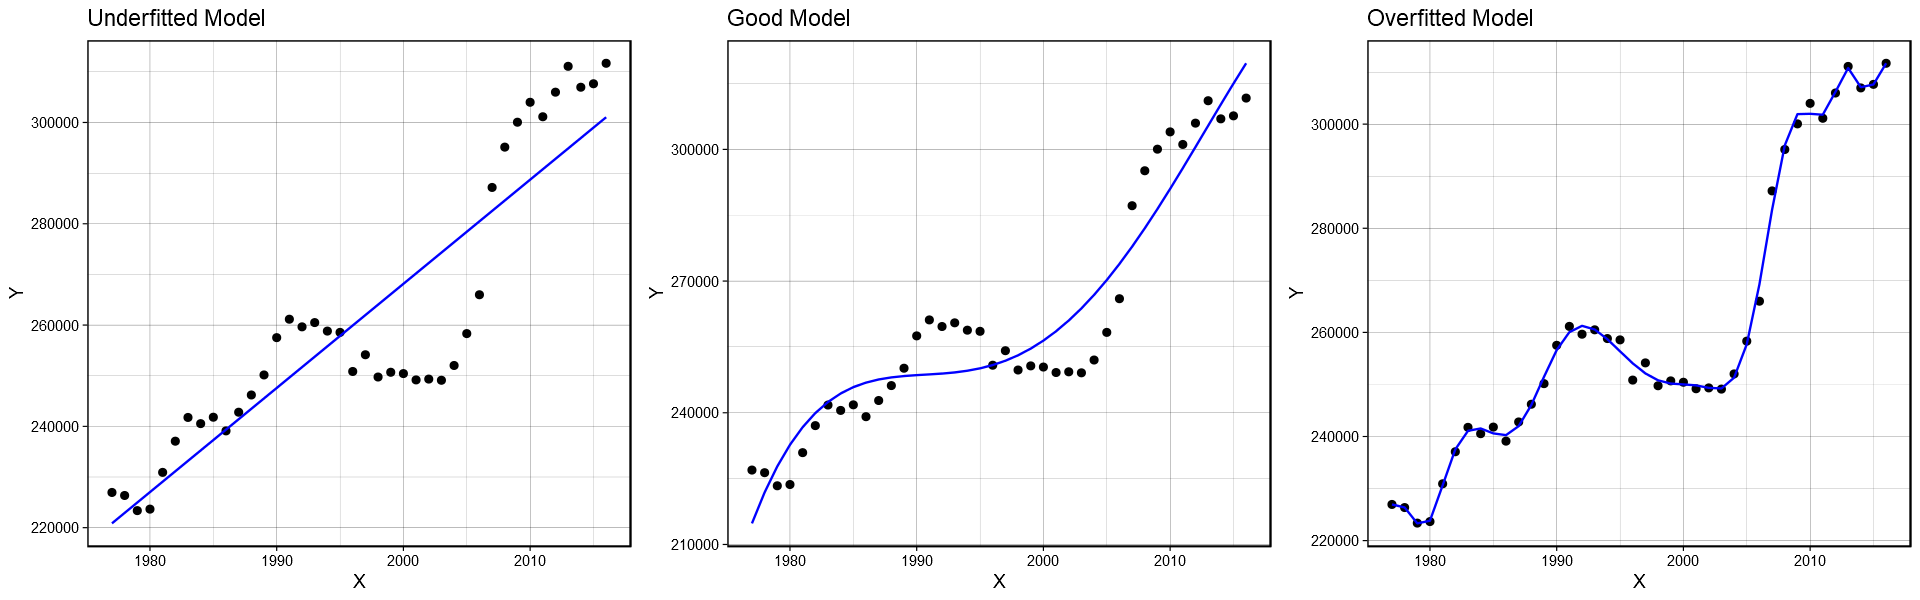

In [38]:
options(repr.plot.width=16, repr.plot.height=5) # area of display

plot1 <- ggplot(births, aes(x = X, y = Y)) + geom_point() + 
theme_linedraw() + 
ggtitle("Underfitted Model") + geom_line(color='blue', data = births, aes(x=X, y=A))

plot2 <- ggplot(births, aes(x = X, y = Y)) + geom_point() + 
theme_linedraw() + 
ggtitle("Good Model") +  geom_line(color='blue', data = births, aes(x=X, y=B))

plot3 <- ggplot(births, aes(x = X, y = Y)) + geom_point() + 
theme_linedraw() + 
ggtitle("Overfitted Model") +  geom_line(color='blue', data = births, aes(x=X, y=C))

grid.arrange(plot1, plot2, plot3, nrow = 1) # display of first plot

# Artificial Dataset

In [58]:
set.seed(1)

In [130]:
x1 <- rnorm(100, 10)
x2 <- 2*x1 + rnorm(100, 10)
x3 <- 5*x1 + rnorm(100, 55)
eps <- rnorm(100, 100, 100)

b0 <- 2
b1 <- 30
b2 <- -10
b3 <- 5

X1 <-  b1 * x1 
X2 <-  b1 * x2 
X3 <-  b1 * x3 

Y <- b0 + X1 + X2 + X3 + eps

In [152]:
# Generate data
set.seed(19875)  # Set seed for reproducibility
n <- 1000  # Number of observations
p <- 5  # Number of predictors included in model
real_p <- 5  # Number of true predictors
x <- matrix(rnorm(n*p), nrow=n, ncol=p)
y <- apply(x[,1:real_p], 1, sum) + rnorm(n)

# Split data into train (2/3) and test (1/3) sets
train_rows <- sample(1:n, .66*n)
x.train <- x[train_rows, ]
x.test <- x[-train_rows, ]

y.train <- y[train_rows]
y.test <- y[-train_rows]

In [153]:
df <- data.frame(x)

In [154]:
Davis <- data.frame("X1" = df$X1, "X2" = df$X2, "X3" = df$X3, "Y" = y)

In [155]:
train.index <- sample(1:nrow(Davis),900)
train.data <- Davis[train.index, c('X1', 'X2', 'X3')]
train.label <- Davis[train.index, 'Y']
test.data <- Davis[-train.index, c('X1', 'X2', 'X3')]
test.label <- Davis[-train.index, 'Y']

In [156]:
fitAndPlot <- function(train.data, train.label, alpha=0, lambda = c(0:5000)/1000){
    # fit the model
    fit <- glmnet(x = as.matrix(train.data), y=train.label, alpha = alpha, lambda = lambda)

    # aggrigate the outputs
    out <- as.data.frame(as.matrix(t(fit$beta)))
    out[,c('nonzero', 'lambda')] <- c(fit$df, fit$lambda)

    # reshape the outputs (for plotting)
    out.m<-melt(out, id=c('lambda', 'nonzero'))
    names(out.m) <- c('lambda', 'nonzero', 'feature', 'coefficient')

    # plot coefficients vs lambda 
    g <- ggplot(data = out.m, aes(x=log(lambda), y=coefficient, color=factor(feature))) + geom_line() +
        ggtitle('Coefficients vs. lambda') + theme_minimal()
    print(g)
    
#     # plot number of nonzero coefficients (as ameasure of model complexity) vs lambda 
#     g <- ggplot(data = out.m, aes(x=log(lambda), y=nonzero)) + geom_line() + 
#        scale_color_discrete(guide = guide_legend(title = NULL)) + 
#        ggtitle('Nonzero Coefficients vs. lambda') + theme_minimal()
#     print(g)
    
    # run the predictions
    train.predict <- predict(fit, newx=as.matrix(train.data))
    test.predict <- predict(fit, newx=as.matrix(test.data))

    # calculate the standard errors
    error <- data.frame('lambda' = out$lambda, 
                    'train' = sqrt(colSums((train.predict - train.label)^2)/nrow(train.predict)),
                    'test' = sqrt(colSums((test.predict - test.label)^2)/nrow(test.predict)))
    error.m <- melt(error, id='lambda')
    names(error.m) <- c('lambda', 'set', 'SE')

    # plot sum of squarred error for train and test sets vs lambda 
    g <- ggplot(data = error.m, aes(x= log(lambda), y = SE, color = factor(set))) + geom_line() +  ylim(0,6) +
        scale_color_discrete(guide = guide_legend(title = NULL)) + 
        ggtitle('Sum of squarred errors vs. lambda') + theme_minimal()
    print(g)
}

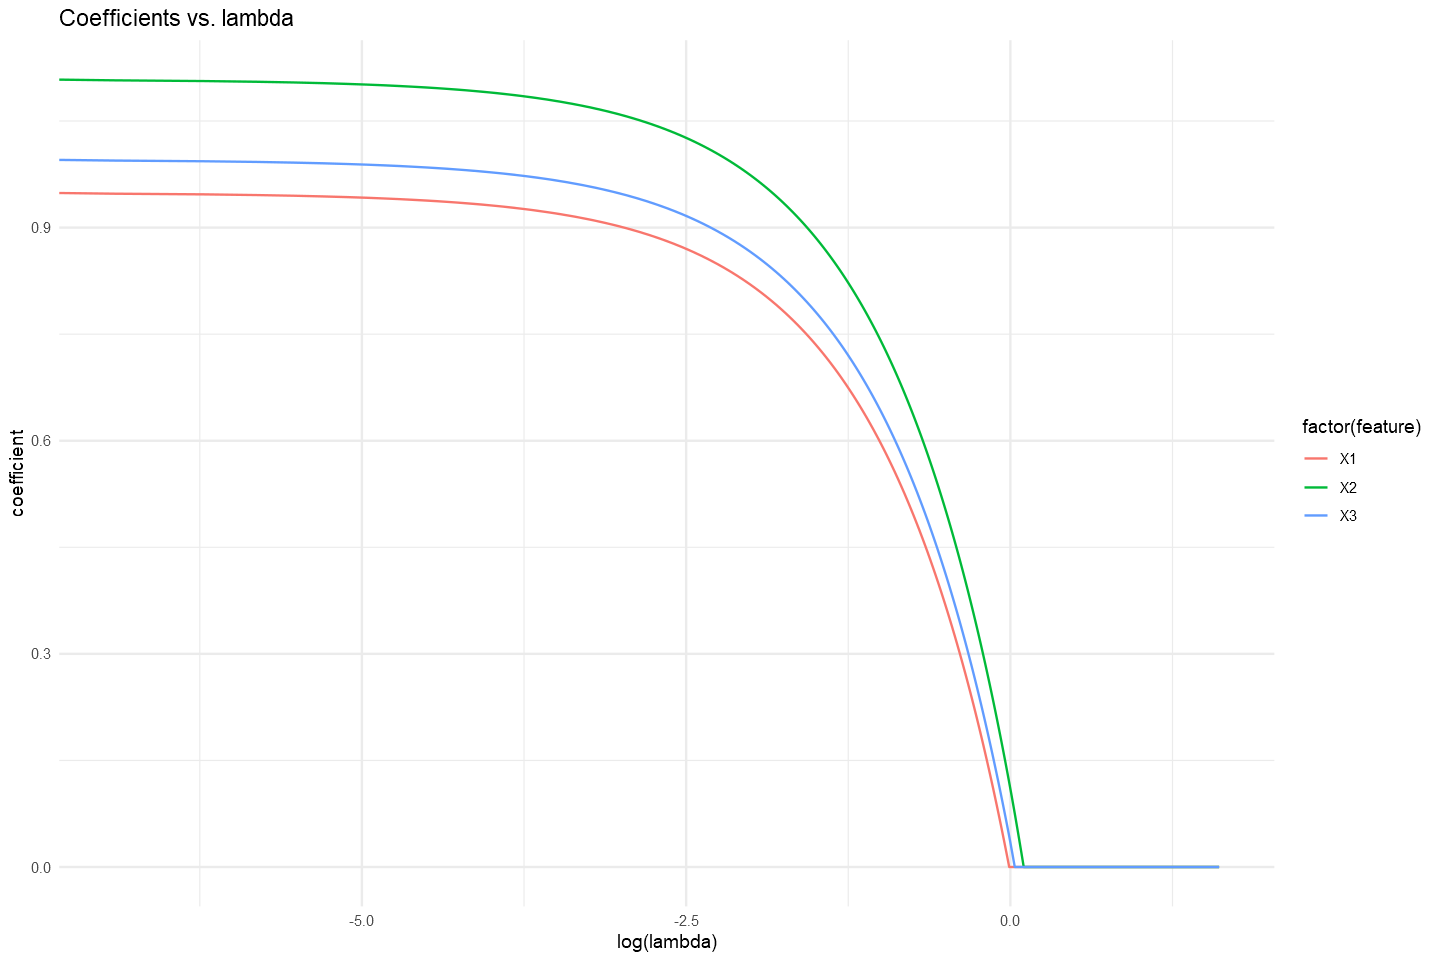

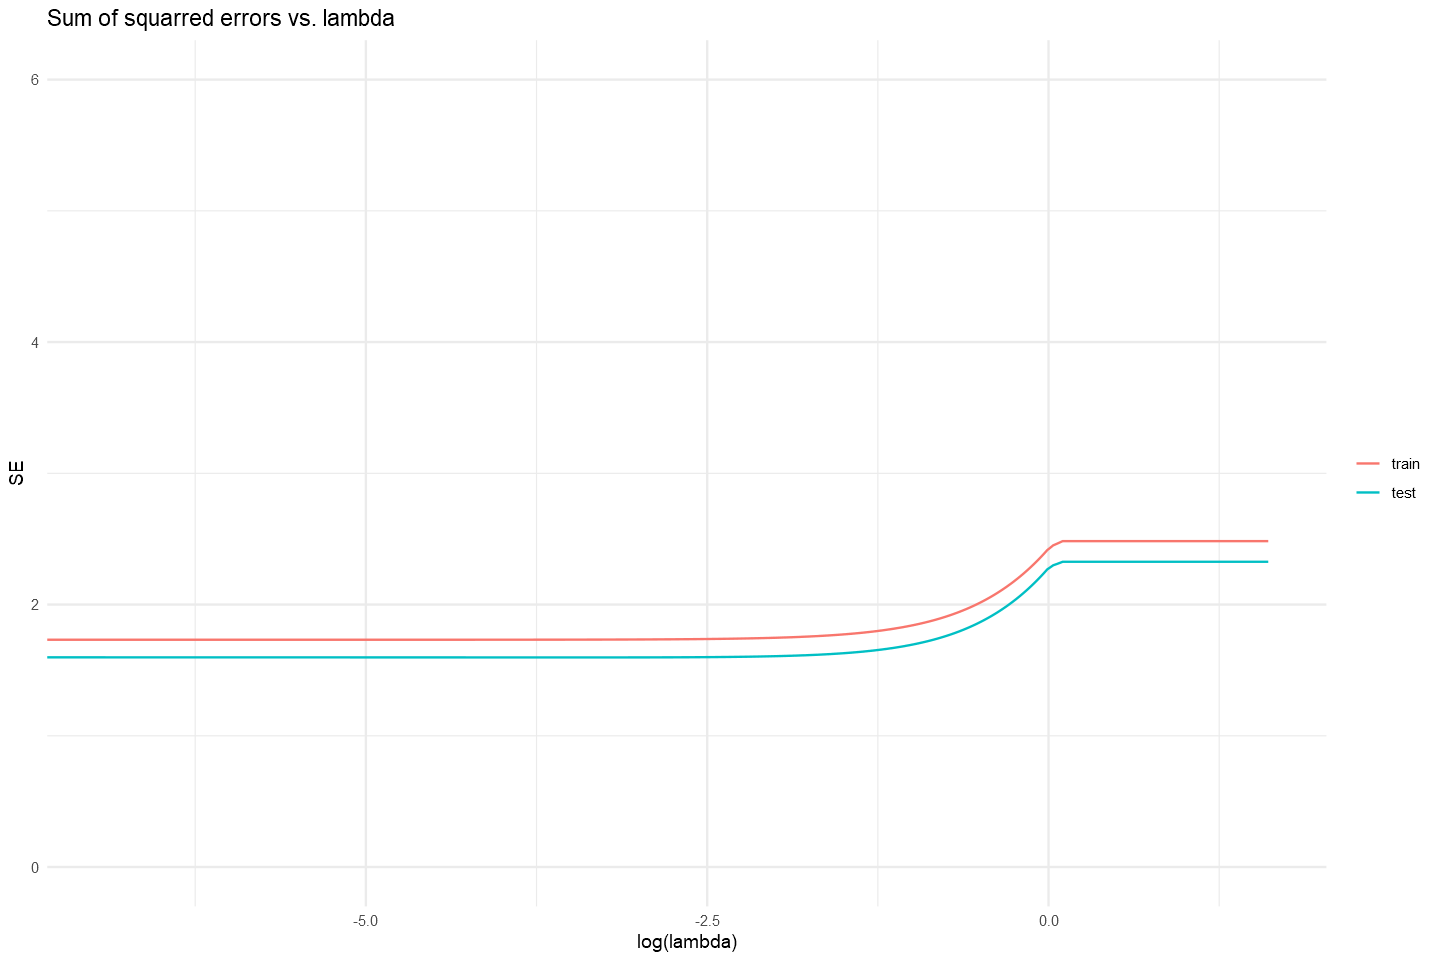

In [157]:
options(repr.plot.width=12, repr.plot.height=8) # area of display

fitAndPlot (train.data, train.label, alpha=1, lambda = c(0:5000)/1000)

In [158]:
fit <- glmnet(x = as.matrix(train.data), y=train.label,  alpha=1, lambda = c(0:5000)/1000)

# aggrigate the outputs
out <- as.data.frame(as.matrix(t(fit$beta)))
out[,c('nonzero', 'lambda')] <- c(fit$df, fit$lambda)
out

,X1,X2,X3,nonzero,lambda
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
s0,0,0,0,0,5.000
s1,0,0,0,0,4.999
s2,0,0,0,0,4.998
s3,0,0,0,0,4.997
s4,0,0,0,0,4.996
s5,0,0,0,0,4.995
s6,0,0,0,0,4.994
s7,0,0,0,0,4.993
s8,0,0,0,0,4.992


# Analysing the Soccer Dataset

In [58]:
soccer <- read.csv('FullData.csv')
soccer <- as.matrix(soccer)
soccer <- na.omit(soccer)

x <- soccer[ ,5:10]
y <- soccer[,2]

# Generate data
set.seed(19875)  # Set seed for reproducibility
n <- nrow(soccer)  # Number of observations
# p <- 5000  # Number of predictors included in model
# real_p <- 15  # Number of true predictors
# x <- matrix(rnorm(n*p), nrow=n, ncol=p)
# y <- apply(x[,1:real_p], 1, sum) + rnorm(n)

# Split data into train (2/3) and test (1/3) sets
train_rows <- sample(1:n, .66*n)
x.train <- x[train_rows, ]
x.test <- x[-train_rows, ]

y.train <- y[train_rows]
y.test <- y[-train_rows]

In [61]:
# Fit models 
# (For plots on left):
fit.lasso <- glmnet(x.train, y.train, family="gaussian", alpha=1)
fit.ridge <- glmnet(x.train, y.train, family="gaussian", alpha=0)
fit.elnet <- glmnet(x.train, y.train, family="gaussian", alpha=.5)


# # 10-fold Cross validation for each alpha = 0, 0.1, ... , 0.9, 1.0
# # (For plots on Right)
# for (i in 0:10) {
#     assign(paste("fit", i, sep=""), cv.glmnet(x.train, y.train, type.measure="mse", alpha=i/10,family="gaussian"))
# }

ERROR: Error in cbind2(1, newx) %*% nbeta: invalid class 'NA' to dup_mMatrix_as_dgeMatrix


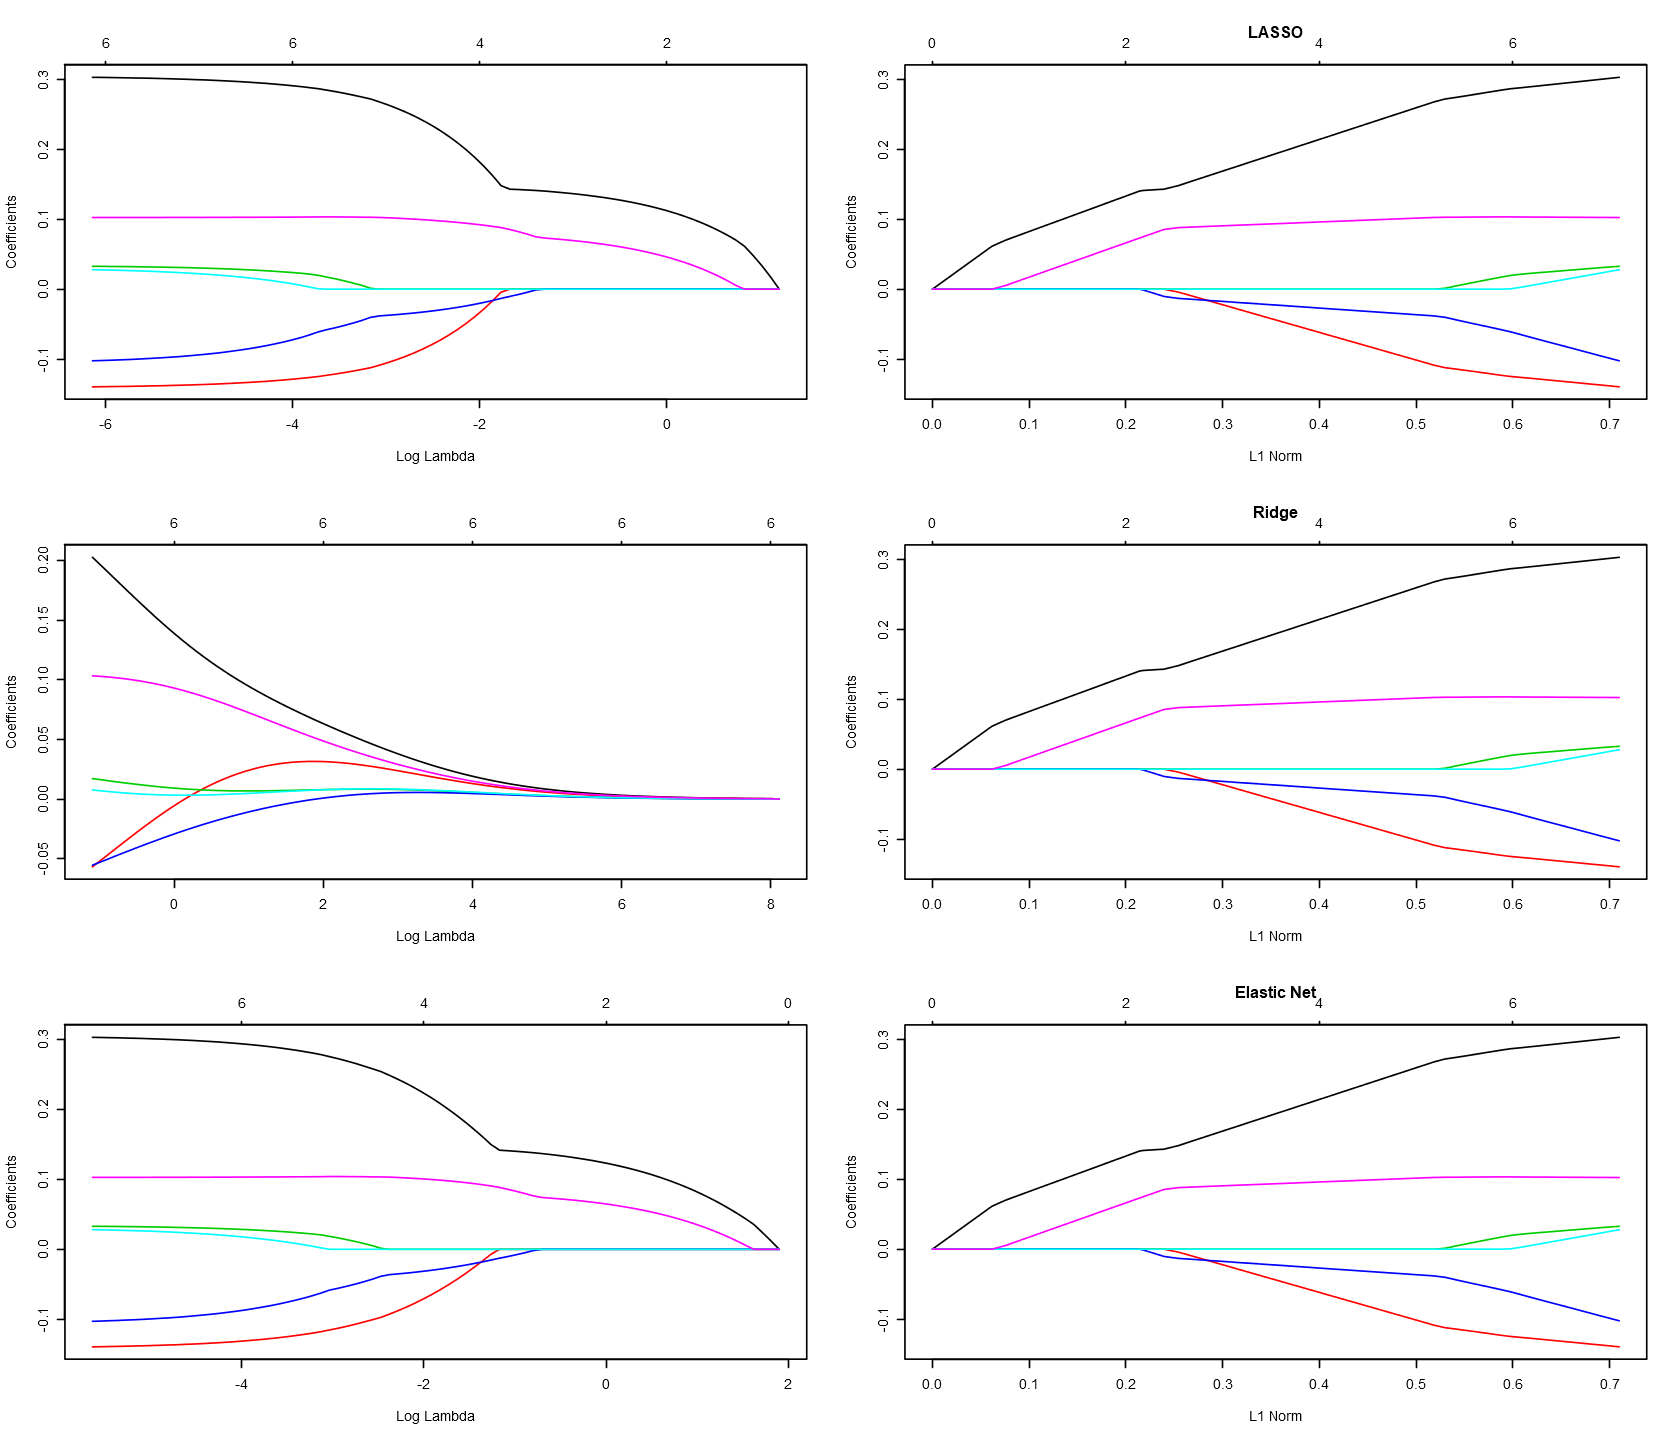

In [66]:
options(repr.plot.width=14, repr.plot.height=12) # area of display

# Plot solution paths:
par(mfrow=c(3,2))
# For plotting options, type '?plot.glmnet' in R console
plot(fit.lasso, xvar="lambda")
plot(fit, main="LASSO")

plot(fit.ridge, xvar="lambda")
plot(fit, main="Ridge")

plot(fit.elnet, xvar="lambda")
plot(fit, main="Elastic Net")

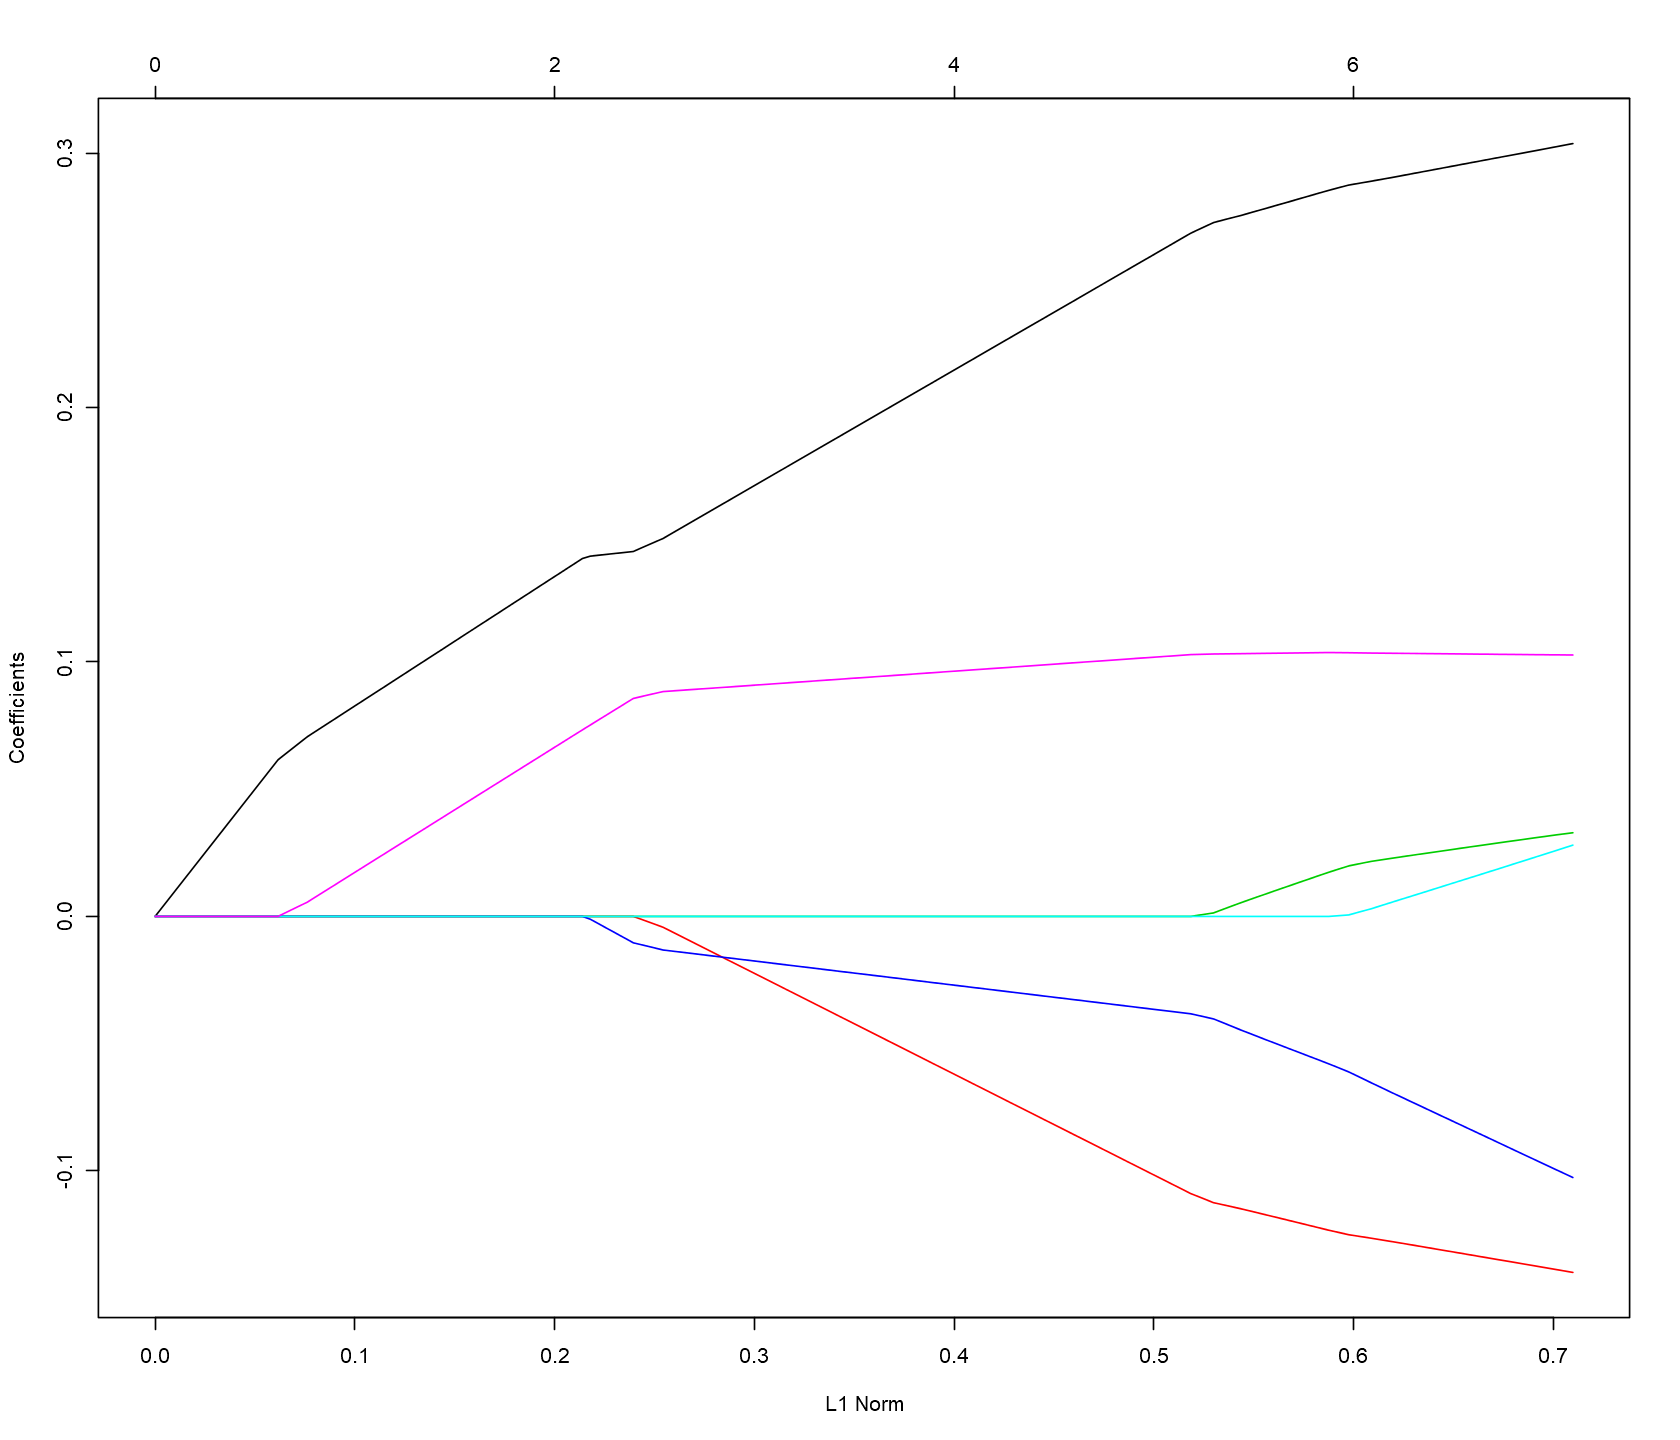

In [63]:
plot(fit)